# Класификација на јазли со Граф невронски мрежи


**Превземано од: https://keras.io/examples/graph/gnn_citations/?fbclid=IwAR2fiLBvF6nVronmW14Tgq_4WBnUxct_vm_u6DqA8rPAoDQRgHdupz-J46s**
**Изработил: Владислав Ристовски, ноември 2022**



Најосновен дел од Граф невронските мрежи  е графот. Графот е структура на податоци која се состои од две компоненти, јазли и рабови. Ако има насочени зависности помеѓу јазлите, тогаш рабовите се насочени. Ако не, рабовите се ненасочени.
Граф невронските мрежи се класа на методи за длабоко учење дизајнирани да изведуваат заклучоци за податоците опишани со графикони. GNN се невронски мрежи кои можат директно да се применат на графиконите и обезбедуваат лесен начин за извршување задачи за предвидување на ниво на јазол, на ниво на раб и на ниво на графикон.

In [6]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

Податочното множество се содржи од 2708 научни трудови класифицирани во една од седум класи. Мрежата на цитати се состои од 5429 врски.

Преземање на множеството

In [7]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

Ги вчитуваме податоците за цитатите во Pandas DataFrame

In [8]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


Сега прикажуваме примерок од цитатите. Target колона ги вклучува идентификациите на трудот цитирани од идентификаторите на трудот во колоната source.

In [9]:
citations.sample(frac=1).head()

,target,source
330,936,3828
673,2665,99023
4599,230879,1130808
4689,252715,601561
2923,36140,323128


Ги вчитуваме податоците за трудовите во Pandas DataFrame

In [10]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


Прикажуваме примерок од трудовите во DataFrame.

In [11]:
print(papers.sample(5).T)

                            2148             2024             1374  \
paper_id                   49753            30817            41216   
term_0                         0                0                0   
term_1                         0                0                0   
term_2                         0                0                0   
term_3                         0                0                0   
...                          ...              ...              ...   
term_1429                      0                0                0   
term_1430                      0                0                0   
term_1431                      0                0                0   
term_1432                      0                0                0   
subject    Probabilistic_Methods  Neural_Networks  Neural_Networks   

                            371              698   
paper_id                  671293            33412  
term_0                         0                0  
ter

Го прикажуваме бројот на трудови напишани за секоја тема

In [12]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


Ги конвертираме редниот број на трудот и темата во индекси кои започнуваат од нула.

In [13]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

Го визуелизираме графиконот на цитати. Секој јазол во графиконот претставува труд, а бојата на јазолот одговара на неговата тема. Прикажан е само примерок од трудовите во базата од трудови.

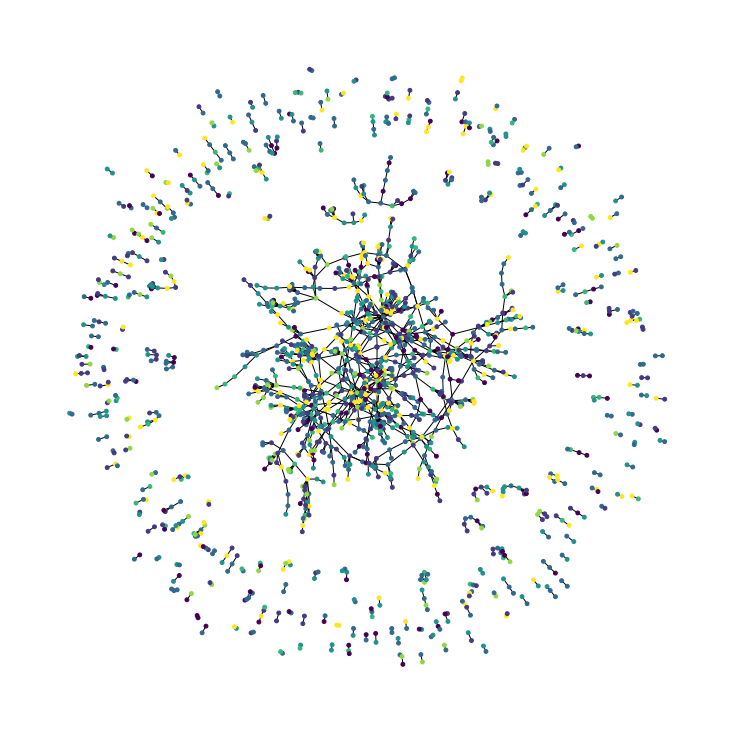

In [14]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

Ја делиме базата на податоци на стратификувани множества за тренирање и тестирање

In [15]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1354, 1435)
Test data shape: (1354, 1435)


Извршување на тренирањето и оценување на експериментот
======================================================
Следните вредности се превземани од интернет заедно со останатиот код

In [16]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

Функција која компајлира и тренира влезен модел користејќи ги дадените податоци за тренирање

In [17]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

Функција која ги прикажува кривите на загуба и точноста на моделот при тренирањето.

In [18]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

Имплементација на Feedforward Network модулот

In [19]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

Градба на основна невронска мрежа
Подготовка на податоците за основната невронска мрежа

In [20]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"].to_numpy()
y_test = test_data["subject"].to_numpy()

C:\Users\Vaci\AppData\Local\Temp\ipykernel_7292\3044936297.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
C:\Users\Vaci\AppData\Local\Temp\ipykernel_7292\3044936297.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


Имплементација на основни класификатори
Додаваме пет FFN блокови со врски за прескокнување, така што генерираме основен модел со приближно ист број параметри како и моделот на GNN што ќе го изградиме подоцна.

In [21]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

Тренирање на основните класификатори

In [22]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 8s 195ms/step - loss: 3.6136 - acc: 0.1643 - val_loss: 1.8934 - val_acc: 0.1176
Epoch 2/300
5/5 [==============================] - 0s 51ms/step - loss: 2.6331 - acc: 0.2348 - val_loss: 1.8604 - val_acc: 0.1912
Epoch 3/300
5/5 [==============================] - 0s 51ms/step - loss: 2.3316 - acc: 0.2400 - val_loss: 1.8704 - val_acc: 0.3676
Epoch 4/300
5/5 [==============================] - 0s 43ms/step - loss: 2.0957 - acc: 0.2809 - val_loss: 1.8601 - val_acc: 0.3676
Epoch 5/300
5/5 [==============================] - 0s 43ms/step - loss: 1.9692 - acc: 0.2809 - val_loss: 1.8318 - val_acc: 0.4461
Epoch 6/300
5/5 [==============================] - 0s 39ms/step - loss: 1.8746 - acc: 0.3243 - val_loss: 1.7928 - val_acc: 0.4755
Epoch 7/300
5/5 [==============================] - 0s 39ms/step - loss: 1.8099 - acc: 0.3348 - val_loss: 1.7522 - val_acc: 0.4951
Epoch 8/300
5/5 [==============================] - 0s 31ms/step - loss: 1.7374 - acc: 0.3

Ги исцртуваме кривите за учење

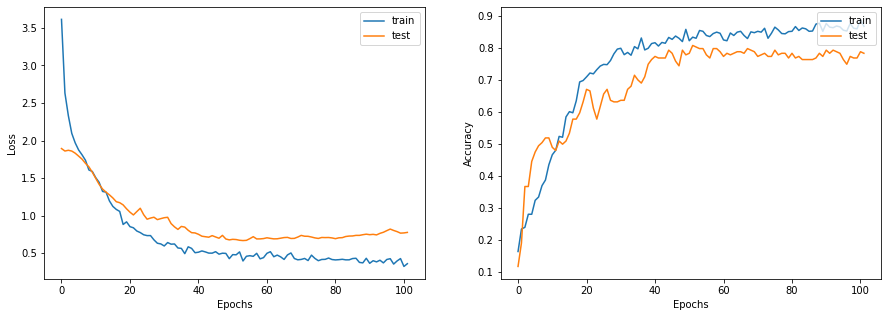

In [23]:
display_learning_curves(history)

Го оценуваме основниот модел на поделба на податоците од тестот

In [26]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.97%


Ги испитуваме предвидувањата на основниот модел
Создаваме нови примероци со случајно генерирање на вектори на бинарни зборови во однос на веројатностите за присуство на зборови

In [27]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

Ги прикажуваме предвидувањата на основниот модел со оглед на случајно генерираните параметри

In [28]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 3s 3s/step
Instance 1:
- Case_Based: 0.66%
- Genetic_Algorithms: 4.61%
- Neural_Networks: 89.88%
- Probabilistic_Methods: 0.67%
- Reinforcement_Learning: 0.96%
- Rule_Learning: 0.61%
- Theory: 2.63%
Instance 2:
- Case_Based: 3.26%
- Genetic_Algorithms: 12.99%
- Neural_Networks: 55.18%
- Probabilistic_Methods: 8.2%
- Reinforcement_Learning: 2.11%
- Rule_Learning: 1.23%
- Theory: 17.03%
Instance 3:
- Case_Based: 0.7%
- Genetic_Algorithms: 57.04%
- Neural_Networks: 16.04%
- Probabilistic_Methods: 23.6%
- Reinforcement_Learning: 1.07%
- Rule_Learning: 0.63%
- Theory: 0.92%
Instance 4:
- Case_Based: 2.04%
- Genetic_Algorithms: 3.87%
- Neural_Networks: 25.75%
- Probabilistic_Methods: 2.15%
- Reinforcement_Learning: 1.2%
- Rule_Learning: 2.62%
- Theory: 62.38%
Instance 5:
- Case_Based: 0.9%
- Genetic_Algorithms: 0.68%
- Neural_Networks: 81.68%
- Probabilistic_Methods: 6.0%
- Reinforcement_Learning: 0.69%
- Rule_Learning: 2.67%
- Theory: 7.38%
Instance 6:

Градење на Граф невронска мрежа
Податоците од графикот се претставени со торката graph_info, која се состои од следните три елементи:

node_features: Ова е [num_nodes, num_features] NumPy низа која ги вклучува карактеристиките на јазлите. Во оваа база на податоци, јазлите се документите, а node_features се бинарните вектори со присуство на збор на секој труд.
edges: Ова е [num_edges, num_edges] NumPy низа што претставува ретка матрица на соседството на врските помеѓу јазлите. Во овој пример, врските се цитати помеѓу трудовите.
edge_weights (опционално): Ова е [num_edges] NumPy низа која ги вклучува тежините на рабовите, кои ги квантифицираат односите помеѓу јазлите во графикот. Во овој пример, нема тежини за цитатите на хартија.

In [29]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


C:\Users\Vaci\AppData\Local\Temp\ipykernel_7292\3360781365.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32


Имплементација на слој за конволуција на графиконот
Ние имплементираме модул за конволуција на графикони како Keras Layer. Нашиот GraphConvLayer ги извршува следниве чекори:

Prepare: Претставите на влезните јазли се обработуваат со помош на FFN за да се произведе порака.
Aggregate: Пораките на соседите на секој јазол се собираат во однос на edge_weights со користење на операција за здружување со непроменлива пермутација, како што се сума, средна вредност и максимум, за да се подготви една збирна порака за секој јазол.
Update: Повторувањата на јазлите и збирните_пораки - и двете со облик [num_nodes, presentation_dim] - се комбинираат и обработуваат за да се произведе новата состојба на претставите на јазлите (вградување на јазли).
Имплементираната техника користи идеи од Graph Convolutional Networks, GraphSage, Graph Isomorphism Network, Simple Graph Networks и Gated Graph Sequence Neural Networks.

In [30]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

Имплементирање на графички класификатор на јазли на невронска мрежа

In [31]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

Тестираме инстанцирање и повикување на моделот GNN. Ако обезбедиме индекси на N јазли, излезот ќе биде тензор со облик [N, num_classes], без оглед на големината на графикот.

In [32]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.07707148  0.03349327 -0.07901328  0.10852873 -0.05743517 -0.02207329
   0.00906519]
 [ 0.03212643 -0.05458915 -0.1156814  -0.03597032 -0.03754337  0.01681572
   0.02022202]
 [-0.00981891 -0.00054826  0.03376161  0.16087668  0.08557203 -0.08880842
   0.0842222 ]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                            

Тренирање на GNN моделот

In [33]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 10s 409ms/step - loss: 2.3487 - acc: 0.1243 - val_loss: 1.8713 - val_acc: 0.4020
Epoch 2/300
5/5 [==============================] - 1s 211ms/step - loss: 2.0161 - acc: 0.2087 - val_loss: 1.8390 - val_acc: 0.4020
Epoch 3/300
5/5 [==============================] - 1s 215ms/step - loss: 1.9419 - acc: 0.2765 - val_loss: 1.8231 - val_acc: 0.4020
Epoch 4/300
5/5 [==============================] - 1s 242ms/step - loss: 1.8954 - acc: 0.2722 - val_loss: 1.8124 - val_acc: 0.4020
Epoch 5/300
5/5 [==============================] - 1s 230ms/step - loss: 1.8830 - acc: 0.2800 - val_loss: 1.8103 - val_acc: 0.4020
Epoch 6/300
5/5 [==============================] - 1s 215ms/step - loss: 1.8859 - acc: 0.2643 - val_loss: 1.8119 - val_acc: 0.4020
Epoch 7/300
5/5 [==============================] - 1s 207ms/step - loss: 1.8652 - acc: 0.2635 - val_loss: 1.8035 - val_acc: 0.4020
Epoch 8/300
5/5 [==============================] - 1s 238ms/step - loss: 1.8505 - 

Ги исцртуваме кривите на учење

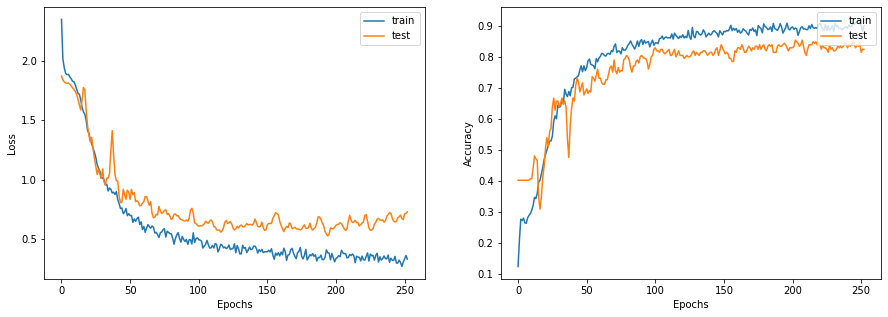

In [34]:
display_learning_curves(history)

Го оценуваме моделот GNN на поделбата на податоците од тестот. Резултатите може да варираат во зависност од примерокот за обука, но GNN моделот секогаш го надминува основниот модел во однос на точноста на тестот.

In [36]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 80.28%


Ги испитуваме предвидувањата на GNN моделот
Ги додаваме новите примероци како јазли на node_features и генерираме врски(цитати) до постоечките јазли

In [37]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

За крај ги ажурираме node_features и рабовите во моделот GNN.

In [38]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 4s 4s/step
Instance 1:
- Case_Based: 11.26%
- Genetic_Algorithms: 0.95%
- Neural_Networks: 44.17%
- Probabilistic_Methods: 3.38%
- Reinforcement_Learning: 0.43%
- Rule_Learning: 12.91%
- Theory: 26.91%
Instance 2:
- Case_Based: 0.74%
- Genetic_Algorithms: 93.79%
- Neural_Networks: 0.74%
- Probabilistic_Methods: 0.06%
- Reinforcement_Learning: 4.53%
- Rule_Learning: 0.08%
- Theory: 0.07%
Instance 3:
- Case_Based: 0.11%
- Genetic_Algorithms: 0.16%
- Neural_Networks: 15.59%
- Probabilistic_Methods: 81.79%
- Reinforcement_Learning: 1.8%
- Rule_Learning: 0.02%
- Theory: 0.52%
Instance 4:
- Case_Based: 0.2%
- Genetic_Algorithms: 0.07%
- Neural_Networks: 1.52%
- Probabilistic_Methods: 7.64%
- Reinforcement_Learning: 0.04%
- Rule_Learning: 0.08%
- Theory: 90.44%
Instance 5:
- Case_Based: 0.43%
- Genetic_Algorithms: 6.

Може да забележиме дека веројатностите на очекуваните теми(на кои се додадени неколку цитати) се поголеми во споредба со освниот модел

### Во продолжение се извршува истиот код со сменети вредности за hidden_units, learning_rate и dropout_rate


In [78]:
hidden_units = [64, 64]
learning_rate = 0.001
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [79]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [80]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [81]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [82]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"].to_numpy()
y_test = test_data["subject"].to_numpy()

C:\Users\Vaci\AppData\Local\Temp\ipykernel_7292\3044936297.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
C:\Users\Vaci\AppData\Local\Temp\ipykernel_7292\3044936297.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


In [83]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 64)           101924      ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 64)           8832        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 64)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [84]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 7s 191ms/step - loss: 5.6677 - acc: 0.1461 - val_loss: 1.9038 - val_acc: 0.3529
Epoch 2/300
5/5 [==============================] - 0s 43ms/step - loss: 4.5014 - acc: 0.1583 - val_loss: 1.8665 - val_acc: 0.4167
Epoch 3/300
5/5 [==============================] - 0s 47ms/step - loss: 3.8360 - acc: 0.1609 - val_loss: 1.8319 - val_acc: 0.4069
Epoch 4/300
5/5 [==============================] - 0s 39ms/step - loss: 3.3890 - acc: 0.1687 - val_loss: 1.8070 - val_acc: 0.4069
Epoch 5/300
5/5 [==============================] - 0s 39ms/step - loss: 3.1066 - acc: 0.2017 - val_loss: 1.7887 - val_acc: 0.4020
Epoch 6/300
5/5 [==============================] - 0s 39ms/step - loss: 3.0348 - acc: 0.2148 - val_loss: 1.7744 - val_acc: 0.4020
Epoch 7/300
5/5 [==============================] - 0s 43ms/step - loss: 2.9607 - acc: 0.2052 - val_loss: 1.7690 - val_acc: 0.4020
Epoch 8/300
5/5 [==============================] - 0s 39ms/step - loss: 2.9191 - acc: 0.2

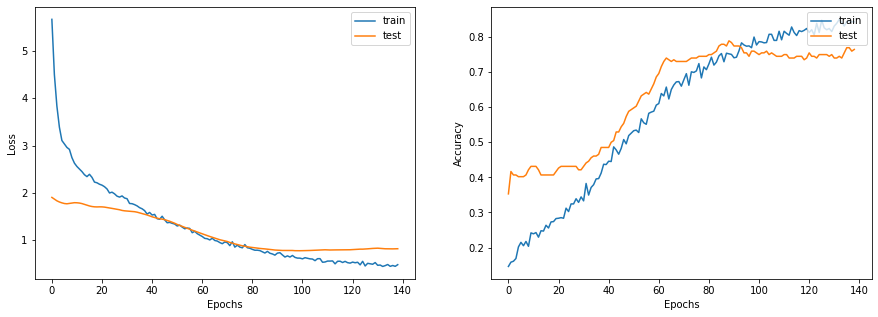

In [85]:
display_learning_curves(history)

In [86]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.26%


In [87]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [88]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 2s 2s/step
Instance 1:
- Case_Based: 4.73%
- Genetic_Algorithms: 1.85%
- Neural_Networks: 23.08%
- Probabilistic_Methods: 51.64%
- Reinforcement_Learning: 2.85%
- Rule_Learning: 5.23%
- Theory: 10.62%
Instance 2:
- Case_Based: 11.01%
- Genetic_Algorithms: 23.99%
- Neural_Networks: 8.55%
- Probabilistic_Methods: 26.24%
- Reinforcement_Learning: 4.34%
- Rule_Learning: 21.95%
- Theory: 3.92%
Instance 3:
- Case_Based: 0.9%
- Genetic_Algorithms: 0.23%
- Neural_Networks: 93.58%
- Probabilistic_Methods: 1.29%
- Reinforcement_Learning: 0.43%
- Rule_Learning: 0.19%
- Theory: 3.38%
Instance 4:
- Case_Based: 10.27%
- Genetic_Algorithms: 18.13%
- Neural_Networks: 36.23%
- Probabilistic_Methods: 23.62%
- Reinforcement_Learning: 3.33%
- Rule_Learning: 2.27%
- Theory: 6.16%
Instance 5:
- Case_Based: 13.86%
- Genetic_Algorithms: 18.11%
- Neural_Networks: 22.53%
- Probabilistic_Methods: 5.64%
- Reinforcement_Learning: 20.12%
- Rule_Learning: 6.49%
- Theory: 13.26%

In [89]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


C:\Users\Vaci\AppData\Local\Temp\ipykernel_7292\3360781365.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32


In [90]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [91]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [92]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.00995926  0.00663196 -0.02127162  0.04104531  0.03439361  0.08638912
   0.0834141 ]
 [ 0.07649067  0.03540421  0.03957725  0.08968902  0.03368552 -0.00687834
   0.06572802]
 [ 0.16083083 -0.03013416 -0.02357249  0.00353459 -0.02910224 -0.05944294
  -0.00258035]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 64)                101924    
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 22016     
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 22016     
 )                                                               
                                                            

In [93]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 11s 578ms/step - loss: 2.4242 - acc: 0.1722 - val_loss: 1.9466 - val_acc: 0.1275
Epoch 2/300
5/5 [==============================] - 2s 320ms/step - loss: 2.2446 - acc: 0.1652 - val_loss: 1.9305 - val_acc: 0.2108
Epoch 3/300
5/5 [==============================] - 2s 301ms/step - loss: 2.2047 - acc: 0.1783 - val_loss: 1.9135 - val_acc: 0.3971
Epoch 4/300
5/5 [==============================] - 2s 309ms/step - loss: 2.1408 - acc: 0.1826 - val_loss: 1.8995 - val_acc: 0.4020
Epoch 5/300
5/5 [==============================] - 1s 301ms/step - loss: 2.1068 - acc: 0.2148 - val_loss: 1.8880 - val_acc: 0.4020
Epoch 6/300
5/5 [==============================] - 2s 312ms/step - loss: 2.0699 - acc: 0.2148 - val_loss: 1.8772 - val_acc: 0.4020
Epoch 7/300
5/5 [==============================] - 1s 297ms/step - loss: 2.0402 - acc: 0.2330 - val_loss: 1.8666 - val_acc: 0.4020
Epoch 8/300
5/5 [==============================] - 2s 301ms/step - loss: 2.0587 - 

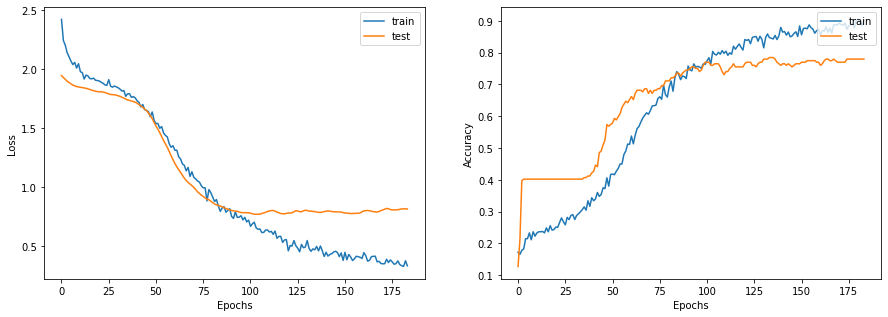

In [94]:
display_learning_curves(history)

In [95]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.22%


In [96]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [97]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 5s 5s/step


На крај може да забележиме дека кодот од проектот кој што е превземан, односно невронската мрежа е тренирана со најдобрите можни вредности за таа мрежа, бидејќи со променети вредности ефикасноста на тестирањето е помала и не се добиваат очекуваните резултати.